# 7 Qubit Error Detection Surface Code

First creating the section of the circuit to detect for phase flip errors

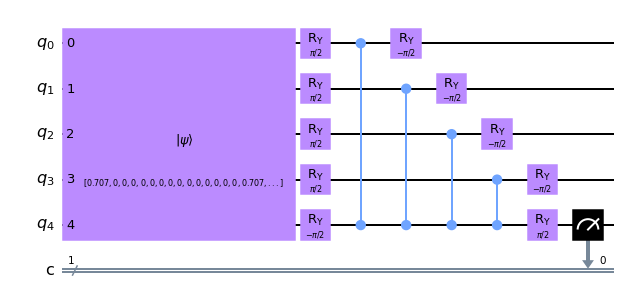

In [1]:
import numpy as np
from math import *
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
initial_state = []
#Initialize to logical 0
for i in range(0,32):
    if i == 0:
        initial_state.append(1/np.sqrt(2))
    elif i == 15:
        initial_state.append(1/np.sqrt(2))
    else:
        initial_state.append(0)
        

sc = QuantumCircuit(5,1)
sc.initialize(initial_state, sc.qubits)



#Surface code
for i in range(0,4):
    sc.ry(pi/2,i)

sc.ry(-pi/2,4)

for i in range(0,4):
    sc.cz(i,4)

for i in range(0,4):
    sc.ry(-pi/2,i)

sc.ry(pi/2,4)

sc.measure(4,0) #measure ancilla qubit
sc.draw('mpl')


{'0': 1000}


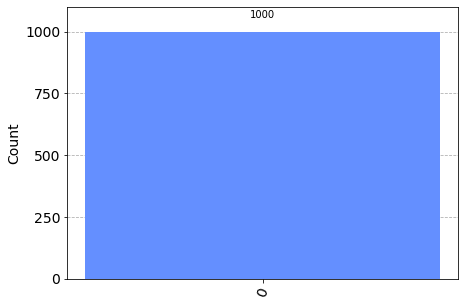

In [2]:
backend = BasicAer.get_backend('qasm_simulator') #The device to run on
result = backend.run(transpile(sc,backend), shots = 1000).result()
counts = result.get_counts() #Get our result


print(counts)
plot_histogram(counts)

In [3]:
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.library import save_statevector
sc.save_statevector()
qobj = assemble(sc)
result = svsim.run(qobj).result()
# Print the statevector neatly:
final_state = result.get_statevector()
array_to_latex(final_state, prefix="\\text{Statevector = }")

NameError: name 'svsim' is not defined

Now creating bit flip section of the circuit

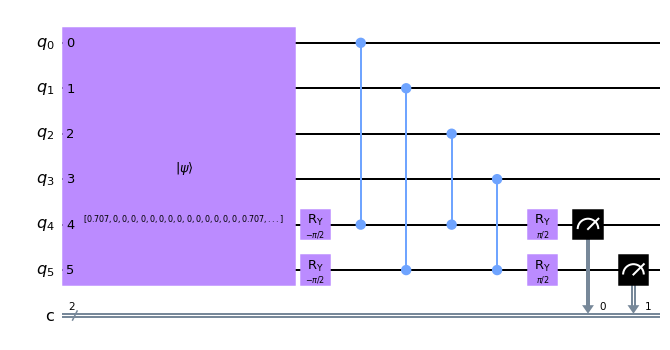

In [4]:
initial_state = []
#Initialize to logical 0
for i in range(0,64):
    if i == 0:
        initial_state.append(1/np.sqrt(2))
    elif i == 15:
        initial_state.append(1/np.sqrt(2))
    else:
        initial_state.append(0)

sc2 = QuantumCircuit(6,2)
sc2.initialize(initial_state, sc2.qubits)
 #Initialize circuit


    
sc2.ry(-pi/2,4)
sc2.ry(-pi/2,5)

sc2.cz(0,4)
sc2.cz(1,5)
sc2.cz(2,4)
sc2.cz(3,5)

sc2.ry(pi/2,4)
sc2.ry(pi/2,5)

sc2.measure(4,0)
sc2.measure(5,1)

sc2.draw('mpl')

{'00': 1000}


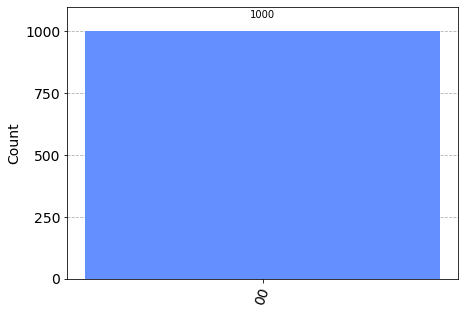

In [5]:
backend = BasicAer.get_backend('qasm_simulator') #The device to run on
result = backend.run(transpile(sc2,backend), shots = 1000).result()
counts = result.get_counts() #Get our result


print(counts)
plot_histogram(counts)

# Full circuit

Creating the full surface code with 7 qubits.

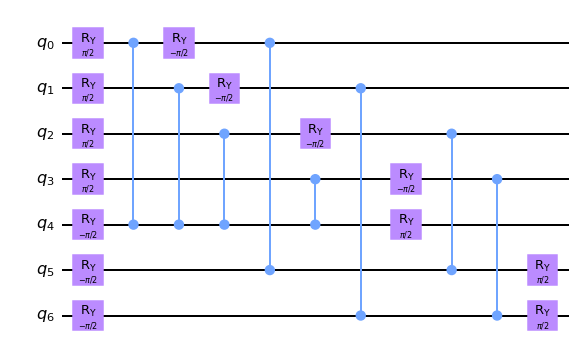

In [6]:
import numpy as np
from math import *
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

sc = QuantumCircuit(7)

#Surface code
for i in range(0,4):
    sc.ry(pi/2,i)

sc.ry(-pi/2,4)

for i in range(0,4):
    sc.cz(i,4)

for i in range(0,4):
    sc.ry(-pi/2,i)

sc.ry(pi/2,4)



sc.ry(-pi/2,5)
sc.ry(-pi/2,6)

sc.cz(0,5)
sc.cz(1,6)
sc.cz(2,5)
sc.cz(3,6)

sc.ry(pi/2,5)
sc.ry(pi/2,6)



sc.draw('mpl')


We can now use this surface code to see how measurements change when different errors are present.

In [7]:
backend = BasicAer.get_backend('qasm_simulator') #The device to run on

initial_state = []
#Initialize to logical 0
for i in range(0,128):
    if i == 0:
        initial_state.append(1/np.sqrt(2))
    elif i == 15:
        initial_state.append(1/np.sqrt(2))
    else:
        initial_state.append(0)


my_gate = sc.to_gate() #create gate from surface code

for i in range(0,4):
    new_circ = QuantumCircuit(7,3) #new circuit 
    new_circ.initialize(initial_state,new_circ.qubits) #initialize
    new_circ.x(i) #bit flip errors
    
    new_circ.append(my_gate, [0,1,2,3,4,5,6]) #7 qubit surface code
    
    new_circ.measure(4,0) #measure ancilla qubits
    new_circ.measure(5,1)
    new_circ.measure(6,2)
    
    result = backend.run(transpile(new_circ,backend), shots = 1000).result()
    counts = result.get_counts() #Get our result
    
    
    print(f'Bit-flip error on qubit {i}',counts)

Bit-flip error on qubit 0 {'010': 1000}
Bit-flip error on qubit 1 {'100': 1000}
Bit-flip error on qubit 2 {'010': 1000}
Bit-flip error on qubit 3 {'100': 1000}


Introducing a noise model.

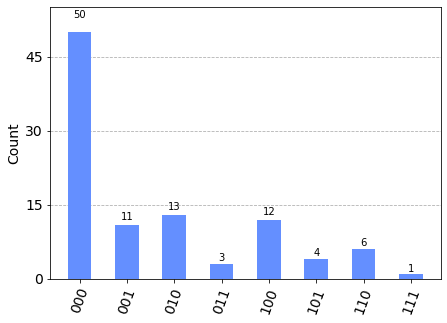

In [10]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import *
import numpy as np

aer_sim = Aer.get_backend('aer_simulator')

def get_noise(p_meas,p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["z"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cz"]) # two qubit gate error is applied to cx gates
        
    return noise_model

noise_model = get_noise(0.1,0.1)

sc = QuantumCircuit(7,3)

initial_state = []
#Initialize to logical 0
for i in range(0,128):
    if i == 0:
        initial_state.append(1/np.sqrt(2))
    elif i == 15:
        initial_state.append(1/np.sqrt(2))
    else:
        initial_state.append(0)

#Surface code
sc.initialize(initial_state,sc.qubits)
for i in range(0,4):
    sc.ry(pi/2,i)

sc.ry(-pi/2,4)

for i in range(0,4):
    sc.cz(i,4)

for i in range(0,4):
    sc.ry(-pi/2,i)

sc.ry(pi/2,4)


sc.ry(-pi/2,5)
sc.ry(-pi/2,6)

sc.cz(0,5)
sc.cz(1,6)
sc.cz(2,5)
sc.cz(3,6)

sc.ry(pi/2,5)
sc.ry(pi/2,6)

sc.measure(4,0)
sc.measure(5, 1)
sc.measure(6, 2)

qobj = assemble(sc)
counts = aer_sim.run(qobj, noise_model=noise_model, shots = 100).result().get_counts()

plot_histogram(counts)